In [1]:
from dotenv import load_dotenv
import os
import mysql.connector as mc
import pyodbc
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash import html, dcc

In [2]:
load_dotenv()

True

In [3]:
from jupyter_dash import JupyterDash
app = JupyterDash(__name__)

In [4]:
def runQuery_tidb(query):
    conn = mc.connect(host=os.getenv('TIDB_HOST'),
                      port=os.getenv('TIDB_PORT'),
                      user=os.getenv('TIDB_USER'),
                      password=os.getenv('TIDB_PW'),
                      database=os.getenv('TIDB_DEFAULT_DATABASE'))
    cur = conn.cursor()
    cur.execute(query)
    ### modify results
    columns = []
    for i in range(len(cur.description)):
        desc = cur.description[i]
        columns.append(str(desc[0]))
    data = pd.DataFrame(cur.fetchall(), columns=columns)
    ### disconnect and return
    # conn.disconnect
    return data

In [5]:
def runQuery_dremio(query):
    host = os.getenv('DREMIO_HOST')
    port = os.getenv('DREMIO_PORT')
    uid = os.getenv('DREMIO_USER')
    pwd = os.getenv('DREMIO_PW')
    driver = os.getenv('DREMIO_DRIVER')

    conn = pyodbc.connect(
        "Driver={};ConnectionType=Direct;HOST={};PORT={};AuthenticationType=Plain;UID={};PWD={}".format(driver, host, port, uid, pwd),
        autocommit=True)

    data = pd.read_sql(query, conn)
    return data

In [6]:
default_start = date.today() - timedelta(days=8)
default_end = date.today() - timedelta(days=1)

In [96]:
def get_raw_data():
    data = runQuery_tidb(f"""
    SELECT
    CONVERT_TZ(FROM_UNIXTIME(psc.cl_date_clicked), 'GMT', 'US/Central') AS timecl,
    DATE_FORMAT(CONVERT_TZ(FROM_UNIXTIME(FLOOR(psc.cl_date_clicked/300)*300),'GMT', 'US/Central'),'%y-%m-%d %H:%i') AS datecl,
    DATE_FORMAT(CONVERT_TZ(FROM_UNIXTIME(FLOOR(psc.cl_date_clicked/300)*300),'GMT', 'US/Central'),'%H:%i') AS h_m,
    psc.cl_id, psc.cl_tracked, psc.cl_approved, psc.cl_refunded, psc.cl_fraud, psc.cl_revenue_xe,

    psc.a_id AS project_id, a.a_name AS project_name, CONCAT('[',psc.a_id,'] ',a.a_name) AS project,
    a.d_id AS merchant_id, d.d_company AS merchant_name, CONCAT('[',a.d_id,'] ',d.d_company) AS merchant,
    psc.ps_id, ps.ps, 
    psc.pss_id, CASE WHEN psc.pss_id=0 OR psc.pss_id IS NULL THEN 'Unknown' ELSE pss.pss END AS pss,
    psc.co_id, co.co_code_alpha3, co.co_name

    FROM (SELECT * FROM ti_paymentwall.ps_clicks WHERE cl_date_clicked > FLOOR(UNIX_TIMESTAMP(NOW() - INTERVAL 3 HOUR)/300)*300) AS psc
    INNER JOIN ti_paymentwall.applications AS a ON psc.a_id = a.a_id
    INNER JOIN ti_paymentwall.developers AS d ON a.d_id = d.d_id
    INNER JOIN (SELECT ps_id, CONCAT('[',ps_id,'] ',ps_name) AS ps FROM ti_paymentwall.payment_systems) AS ps ON psc.ps_id = ps.ps_id
    LEFT JOIN (SELECT pss_id, CONCAT('[',pss_id,'] ',pss_name) AS pss FROM ti_paymentwall.ps_subaccounts) AS pss ON psc.pss_id = pss.pss_id
    INNER JOIN ti_paymentwall.countries AS co ON psc.co_id = co.co_id
    """)

    return data

In [97]:
data = get_raw_data()

In [98]:
data.head()

,timecl,datecl,h_m,cl_id,cl_tracked,cl_approved,cl_refunded,cl_fraud,cl_revenue_xe,project_id,...,merchant_id,merchant_name,merchant,ps_id,ps,pss_id,pss,co_id,co_code_alpha3,co_name
0,2022-04-28 23:07:32,22-04-28 23:05,23:05,284524167,1,1,0,0,1.6891,834,...,1226,Celestia Games,[1226] Celestia Games,309,[309] Desa/Indomaret,NaN,Unknown,94,IDN,Indonesia
1,2022-04-28 23:15:16,22-04-28 23:15,23:15,284524546,0,0,0,0,None,834,...,1226,Celestia Games,[1226] Celestia Games,317,[317] Thamrin/Ovo,NaN,Unknown,94,IDN,Indonesia
2,2022-04-28 23:16:33,22-04-28 23:15,23:15,284524589,0,0,0,0,None,834,...,1226,Celestia Games,[1226] Celestia Games,317,[317] Thamrin/Ovo,NaN,Unknown,94,IDN,Indonesia
3,2022-04-28 23:17:30,22-04-28 23:15,23:15,284524623,1,1,0,0,1.6891,834,...,1226,Celestia Games,[1226] Celestia Games,309,[309] Desa/Indomaret,NaN,Unknown,94,IDN,Indonesia
4,2022-04-28 23:19:40,22-04-28 23:15,23:15,284524740,1,1,0,0,9.3584,834,...,1226,Celestia Games,[1226] Celestia Games,293,[293] Makadi/Gcash,NaN,Unknown,162,PHL,Philippines


## RealTime PW Performance Dataset

In [110]:
def graph_overall_performance(df, click_color, conversion_color, cr_color, show_legend):
    global data
    overall = pd.DataFrame(df.groupby(['datecl']).agg(clicks=pd.NamedAgg(column="cl_id", aggfunc="count"),
                                                             conversions=pd.NamedAgg(column="cl_tracked", aggfunc="sum")
                                                             ).reset_index())
    overall['conversion_rate'] = overall['conversions'] / overall['clicks']
    all_times = pd.DataFrame(data['datecl'].unique(), columns=['datecl']).sort_values(by='datecl').reset_index()
    overall = all_times.merge(overall, on='datecl', how='left').fillna(0)
    overall_graph = make_subplots(specs=[[{"secondary_y": True}]])
    overall_graph.add_trace(go.Bar(x=overall['datecl'], y=overall['clicks'], name="#Clicks", marker_color=click_color),
                            secondary_y=False)
    overall_graph.add_trace(go.Bar(x=overall['datecl'], y=overall['conversions'], name="#Conversions", marker_color=conversion_color),
                            secondary_y=False)
    overall_graph.add_trace(
        go.Scatter(x=overall['datecl'], y=overall['conversion_rate'], name="Conversion Rate", marker_color=cr_color),
        secondary_y=True)
    overall_graph.update_layout(xaxis={'title': 'Time', 'tickformat': '%H:%M'},
                                plot_bgcolor='white', hovermode="x", margin=dict(l=20, r=20, t=0, b=0), showlegend=show_legend)
    overall_graph.update_yaxes(title_text="#Clicks", rangemode="tozero", secondary_y=False)
    overall_graph.update_yaxes(title_text="Conversion Rate (%)", rangemode="tozero", secondary_y=True, range=[0, 1],
                               tickformat=".0%")

    return overall_graph

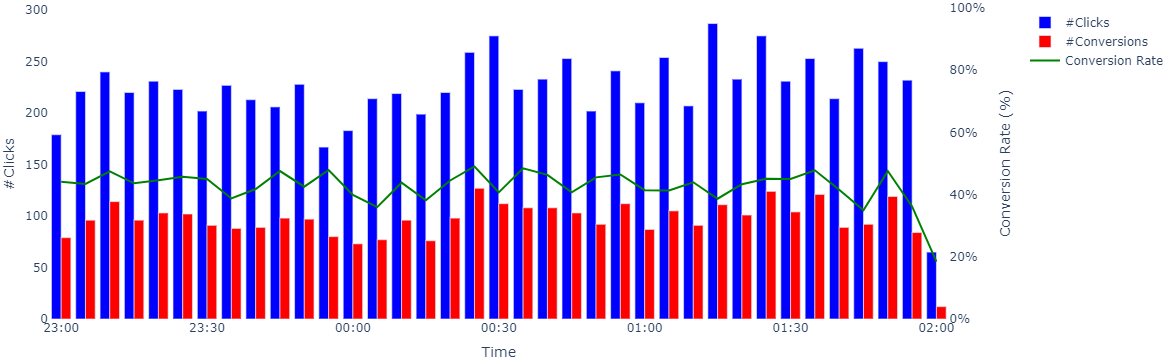

In [111]:
graph_overall_performance(data, click_color='blue', conversion_color='red', cr_color='green', show_legend=True)

In [65]:
def apply_filters(project_id_list, ps_id_list, co_id_list):
    global data
    df = data
    df = df if not project_id_list else df[df['project_id'].isin(project_id_list)]
    df = df if not ps_id_list else df[df['ps_id'].isin(ps_id_list)]
    df = df if not co_id_list else df[df['co_id'].isin(co_id_list)]
    return df

In [27]:
### required: click_color, conversion_color, conversion_rate_color, show_legend
def graph_var_performance(**kwargs):
    project_id_list = None if not 'project_id' in kwargs else kwargs['project_id'] 
    ps_id_list = None if not 'ps_id' in kwargs else kwargs['ps_id'] 
    co_id_list = None if not 'co_id' in kwargs else kwargs['co_id'] 
    df = apply_filters(project_id_list, ps_id_list, co_id_list)
    return graph_overall_performance(df, kwargs['click_color'], kwargs['conversion_color'], kwargs['cr_color'], kwargs['show_legend'])

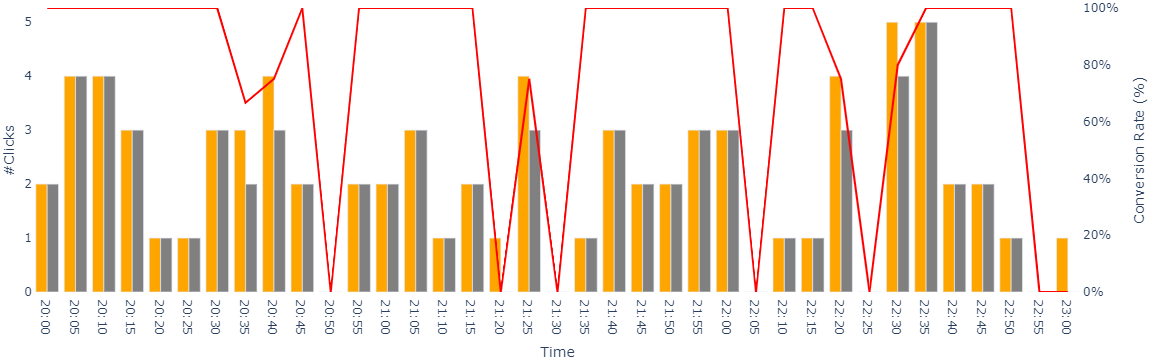

In [89]:
graph_var_performance(project_id=[388099], co_id=[1], ps_id=[1], click_color='orange', conversion_color='grey', cr_color='red', show_legend=False)

## PW Performance Dataset

In [100]:
def graph_project_distribution(df):
    by_projects = df
    by_projects['project_id_str'] = '[' + by_projects['project_id'].astype(str) + ']'
    by_projects = pd.DataFrame(by_projects.groupby(['project','project_id_str']).agg(PV=pd.NamedAgg(column="PV", aggfunc="sum")).reset_index())
    by_projects_graph = px.pie(by_projects, values='PV', names='project')
    by_projects_graph.update_traces(direction='clockwise', text=by_projects['project_id_str'], textposition='inside', textinfo='text+percent',
                                    hovertemplate=None, hoverinfo="label+value+percent")
    by_projects_graph.update_layout(uniformtext_minsize=11, uniformtext_mode='hide', showlegend=False, #, legend_title_text="Project", title_text="Projects' Contribution to Total Volume",
                                    margin=dict(l=20, r=20, t=20, b=20))
    return by_projects_graph

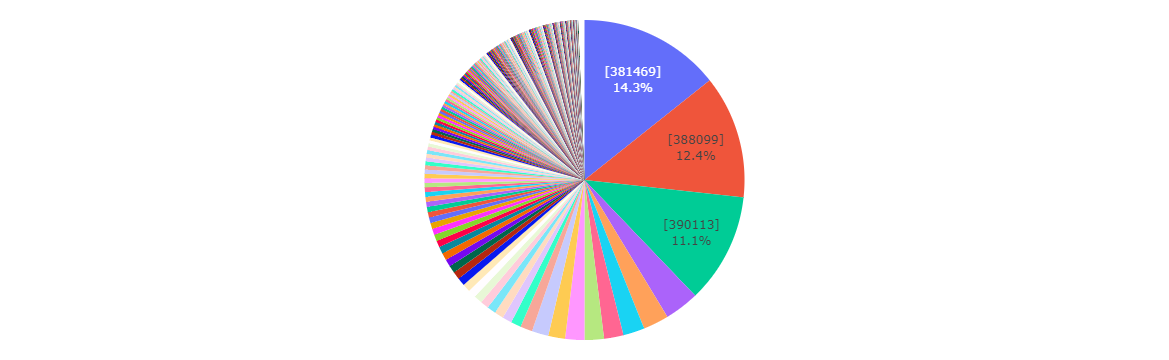

In [101]:
graph_project_distribution(data)

In [329]:
def graph_ps_distribution(df):
    by_ps = pd.DataFrame(df.groupby(['ps','pss']).agg(PV=pd.NamedAgg(column="PV", aggfunc="sum")).reset_index())
    by_ps_graph = px.treemap(by_ps, path=[px.Constant("TOTAL"),'ps', 'pss'], values='PV', color='ps' #,title="Payment Systems' Contribution to Total Volume"
                            )
    by_ps_graph.update_traces(hovertemplate=None, hoverinfo="label+value+percent root+percent entry+percent parent")
    by_ps_graph.update_layout(margin=dict(l=20, r=20, t=20, b=20))
    return by_ps_graph

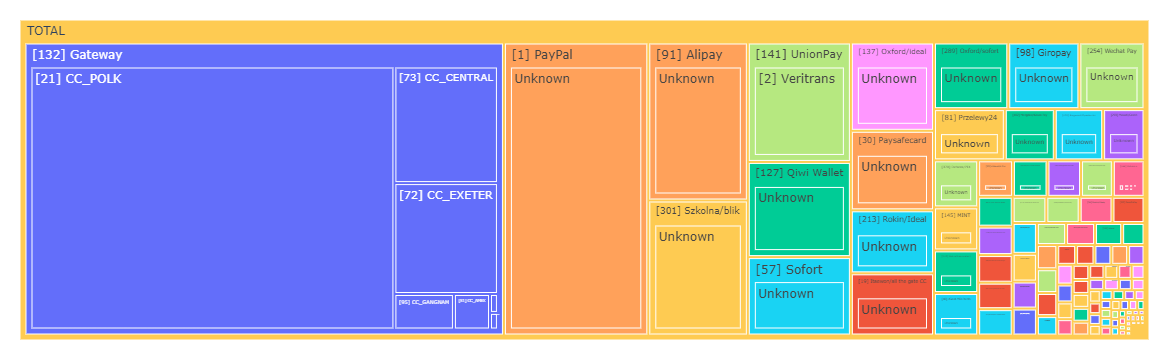

In [330]:
graph_ps_distribution(data)

In [260]:
def graph_countries_distribution(df):
    by_countries = pd.DataFrame(df.groupby(['co_name','co_code_alpha3']).agg(PV=pd.NamedAgg(column="PV", aggfunc="sum")).reset_index())
    by_countries['PV'] = by_countries['PV'].astype(float)
    by_countries['text'] = by_countries['co_name'] + '<br>' + by_countries["PV"].map('{:,.2f}'.format) #hover text
        
    graph_countries_distribution = go.Figure(data=go.Choropleth(
        locations=by_countries['co_code_alpha3'], # Spatial coordinates
        z = by_countries['PV'], # Data to be color-coded
        colorscale='Reds'
    ))
    graph_countries_distribution.update_traces(showscale=False, hovertemplate = by_countries['text'])
    graph_countries_distribution.update_layout(margin={"r":20,"t":20,"l":20,"b":20})
    graph_countries_distribution.update_geos(fitbounds="locations", visible=False)
    
    return graph_countries_distribution

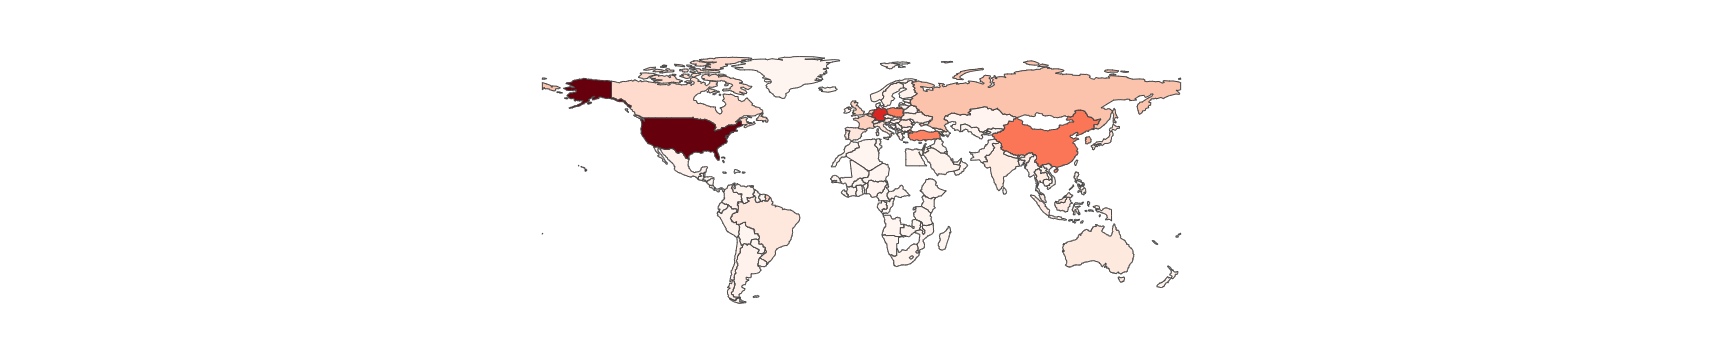

In [261]:
graph_countries_distribution(data)

In [258]:
def graph_countries_distribution(df):
    by_countries = pd.DataFrame(df.groupby(['co_name','co_code_alpha3']).agg(PV=pd.NamedAgg(column="PV", aggfunc="sum")).reset_index())
    by_countries['PV'] = by_countries['PV'].astype(float)
    by_countries['text'] = by_countries['co_name'] + '<br>' + by_countries["PV"].map('{:,.2f}'.format) #hover text
        
    graph_countries_distribution = px.choropleth(
        locations=by_countries['co_code_alpha3'], # Spatial coordinates
        color = by_countries['PV'], # Data to be color-coded
        color_continuous_scale=px.colors.sequential.Plasma
    )
    graph_countries_distribution.update_coloraxes(showscale=False)
    graph_countries_distribution.update_traces(hovertemplate = by_countries['text'])
    graph_countries_distribution.update_layout(margin={"r":20,"t":20,"l":20,"b":20})
    graph_countries_distribution.update_geos(fitbounds="locations", visible=False)
    
    return graph_countries_distribution

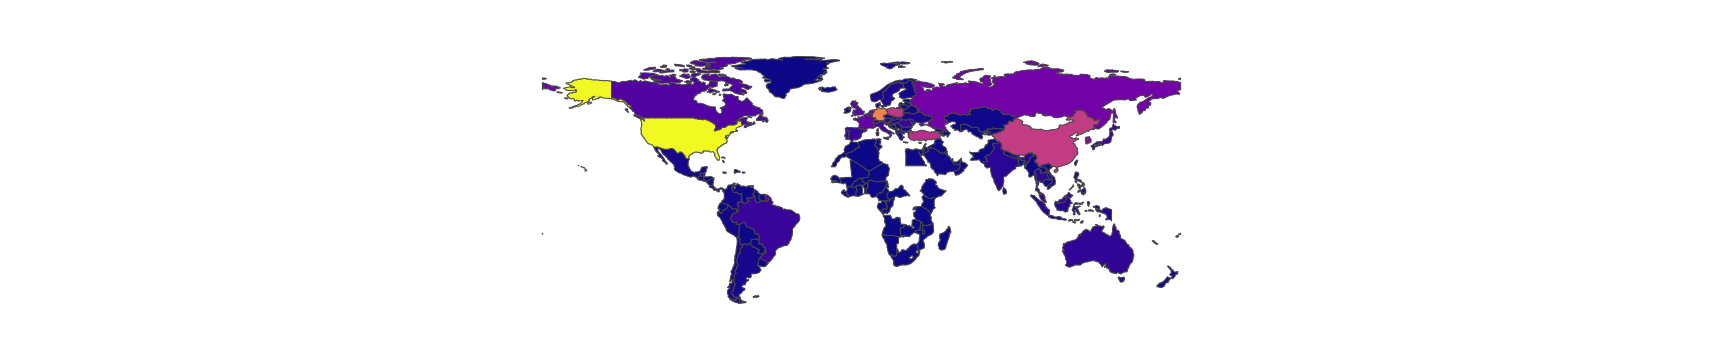

In [259]:
graph_countries_distribution(data)

In [323]:
### GRAPH TOP PROJECT DAILY PV
def graph_top_project_daily_PV(df):
    by_projects = pd.DataFrame(df.groupby(['project','datecl']).agg(PV=pd.NamedAgg(column="PV", aggfunc="sum")).reset_index())
    top10 = pd.DataFrame(df.groupby(['project']).agg(PV=pd.NamedAgg(column="PV", aggfunc="sum")).reset_index()).sort_values(by="PV", ascending=False).head(10)
    by_projects = by_projects[by_projects['project'].isin(top10['project'])]
    
    by_projects_graph = px.area(by_projects, x="datecl", y="PV", color="project", line_group="project")
    by_projects_graph.update_traces(hovertemplate=None)
    by_projects_graph.update_layout(plot_bgcolor='white', hovermode="x", legend_title_text="Project", 
                                   xaxis={'title':'Date'},
                                   yaxis={'title':"Processing Volume",'rangemode':"tozero", 'tickformat':"$,"})
    
    return by_projects_graph

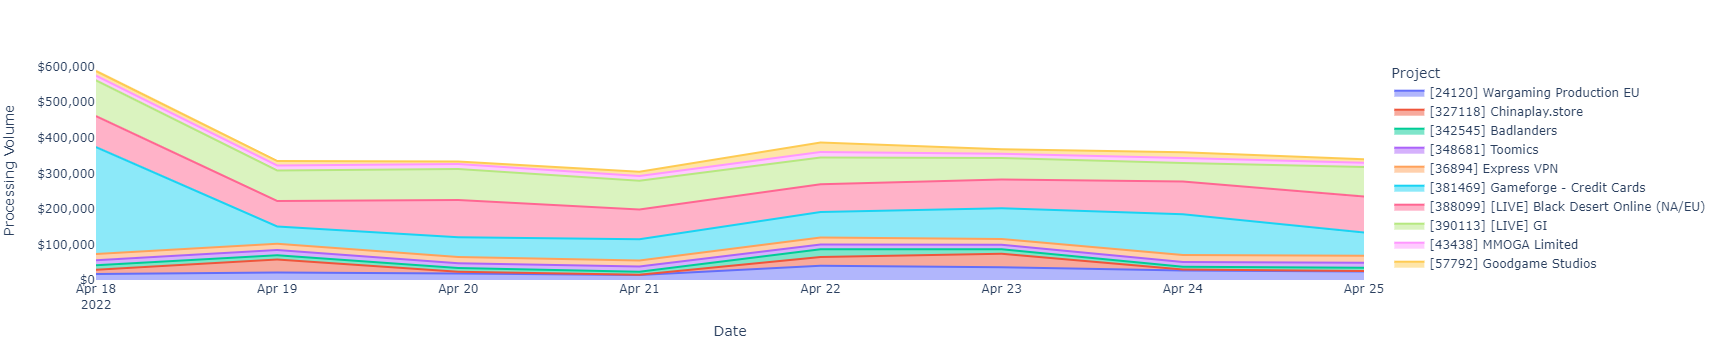

In [324]:
graph_top_project_daily_PV(data)

In [331]:
def graph_top_ps_daily_PV(df):
    by_ps = pd.DataFrame(df.groupby(['ps','datecl']).agg(PV=pd.NamedAgg(column="PV", aggfunc="sum")).reset_index())
    top10 = pd.DataFrame(df.groupby(['ps']).agg(PV=pd.NamedAgg(column="PV", aggfunc="sum")).reset_index()).sort_values(by="PV", ascending=False).head(10)
    by_ps = by_ps[by_ps['ps'].isin(top10['ps'])]
    
    by_ps_graph = px.area(by_ps, x="datecl", y="PV", color="ps", line_group="ps")
    by_ps_graph.update_traces(hovertemplate=None)
    by_ps_graph.update_layout(plot_bgcolor='white', hovermode="x", legend_title_text="Payment System", 
                                   xaxis={'title':'Date'},
                                   yaxis={'title':"Processing Volume",'rangemode':"tozero", 'tickformat':"$,"})
    
    return by_ps_graph

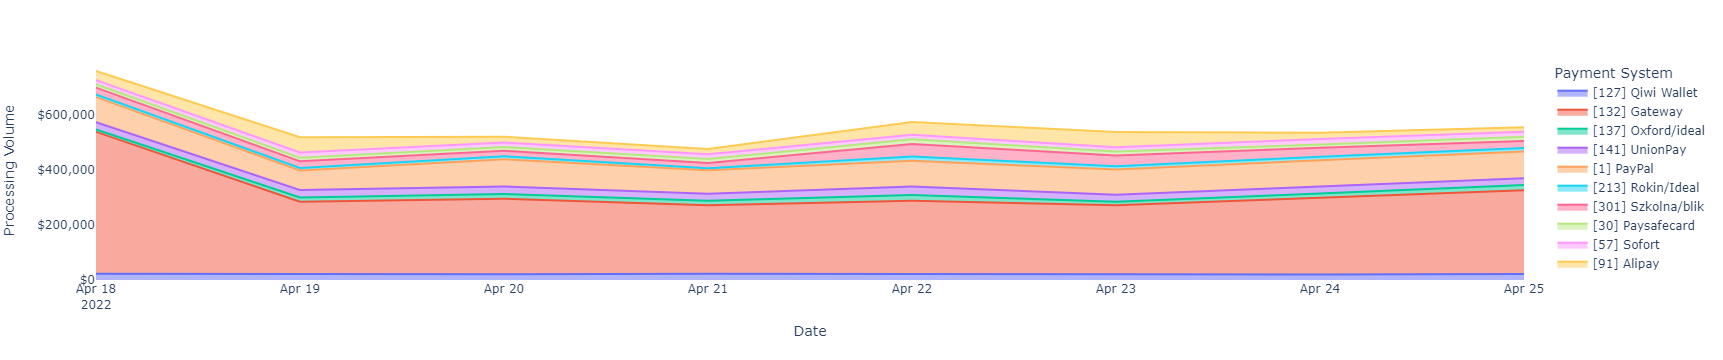

In [332]:
graph_top_ps_daily_PV(data)

In [208]:
import dash_bootstrap_components as dbc

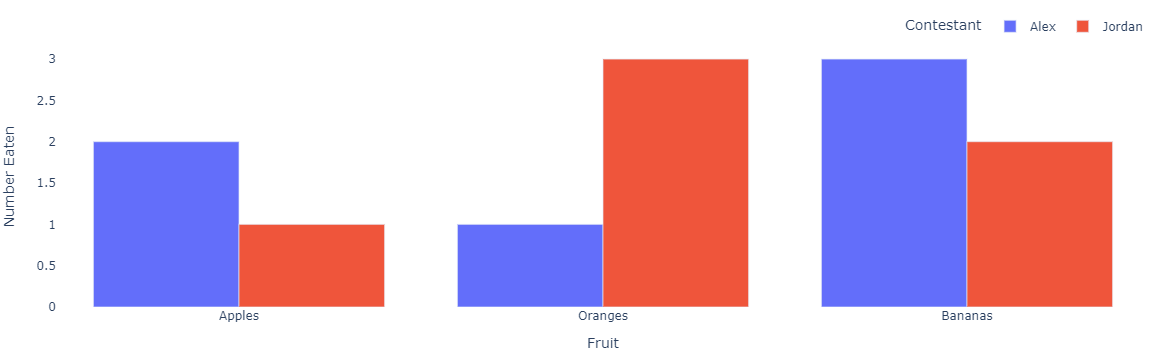

In [338]:

# 2.
df2 = px.data.gapminder()

fig2 = px.scatter(df2.query("year==2007"), x="gdpPercap", y="lifeExp",size="pop", color="continent",hover_name="country", log_x=True, size_max=60)
fig2.update_layout(plot_bgcolor='white')
fig2.update_layout(margin=dict(l=20, r=20, t=20, b=20),
                   legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
                   )

# 3.
df3 = px.data.gapminder().query("year==2007")
fig3 = px.choropleth(df3, locations="iso_alpha",
                    color="lifeExp", # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma,
                     )
fig3.update_coloraxes(showscale=False)
fig3.update_layout(margin=dict(l=0, r=0, t=0, b=0), autosize=False)
fig3.update_geos(fitbounds="locations", visible=False)

# 4.
df4 = pd.DataFrame({
  "Fruit": ["Apples", "Oranges", "Bananas", "Apples", "Oranges", "Bananas"],
  "Contestant": ["Alex", "Alex", "Alex", "Jordan", "Jordan", "Jordan"],
  "Number Eaten": [2, 1, 3, 1, 3, 2],
})
fig4 = px.bar(df4, x="Fruit", y="Number Eaten", color="Contestant", barmode="group")
fig4.update_layout(plot_bgcolor='white')
fig4.update_layout(margin=dict(l=20, r=20, t=20, b=20),
                   legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
                   )

In [339]:
app.layout = html.Div(
    [
        dbc.Row([
            dbc.Col(dbc.Row([html.H4("Bubble chart"), dcc.Graph(id='fig2',figure=fig2)]) ,md=4),
            dbc.Col(dbc.Row([html.H4("Map chart"), dcc.Graph(id='fig3',figure=fig3)]) ,md=4),
            dbc.Col(dbc.Row([html.H4("Bar chart"), dcc.Graph(id='fig4',figure=fig4)]) ,md=4),
        ])
    ]
)

In [340]:
app.run_server(mode='inline')